# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [181]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [182]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

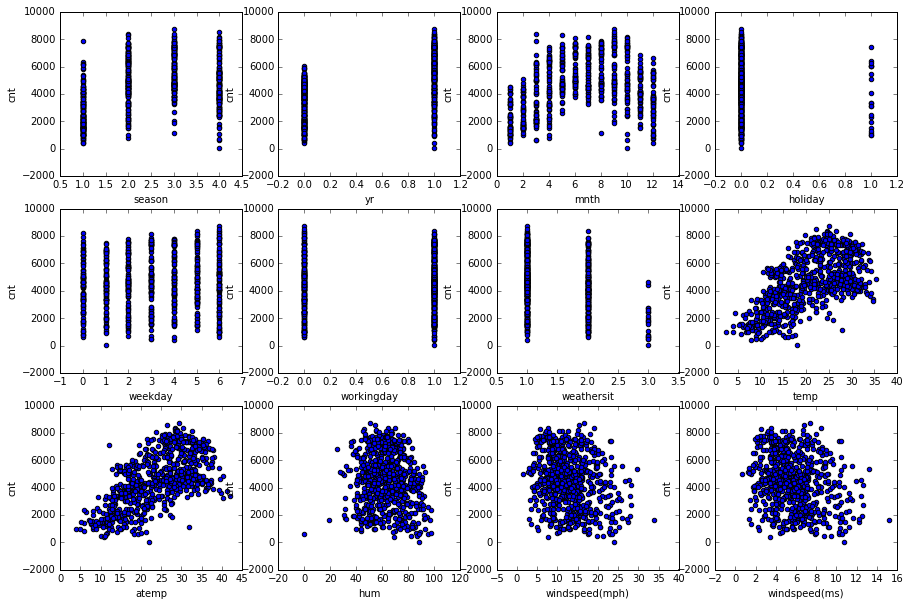

In [183]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * __Ответ: По третьему графику в первом ряду видно, что в летние месяцы количество прокатов возрастает, а к зиме убывает.__
2. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * __Ответ: Температура (temp) и Скорость ветра (windspeed)__

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [184]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df.corrwith(df.cnt)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [185]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[df.columns[7:]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [186]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
np.mean(df)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [187]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [188]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [189]:
from sklearn.linear_model import LinearRegression

In [190]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
linear_regressor = LinearRegression()
linear_regressor.fit(X,y)
rnd = 3

print("Intercept : "+str.format(str(round(linear_regressor.intercept_,rnd))))
for i, coef in zip(range(len(df.columns[:-1])),linear_regressor.coef_):
    print(str(df.columns[i])+" : "+str(round(coef,rnd)))

Intercept : 4504.355
season : 570.869
yr : 1021.963
mnth : -141.305
holiday : -86.758
weekday : 137.225
workingday : 56.389
weathersit : -330.229
temp : 367.48
atemp : 585.551
hum : -145.611
windspeed(mph) : 1.24582607593e+13
windspeed(ms) : -1.24582607595e+13


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [191]:
from sklearn.linear_model import Lasso, Ridge

In [192]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией
Lasso_reg = Lasso()
Lasso_reg.fit(X,y)
rnd = 3

print("Intercept : "+str.format(str(round(Lasso_reg.intercept_,rnd))))
for i, coef in zip(range(len(df.columns[:-1])),Lasso_reg.coef_):
    print(str(df.columns[i])+" : "+str(round(coef,rnd)))

Intercept : 4504.349
season : 560.242
yr : 1019.463
mnth : -128.731
holiday : -86.153
weekday : 137.348
workingday : 55.212
weathersit : -332.37
temp : 376.363
atemp : 576.531
hum : -144.129
windspeed(mph) : -197.14
windspeed(ms) : -0.0


In [195]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией
Ridge_reg = Ridge()
Ridge_reg.fit(X,y)
rnd = 3

print("Intercept : "+str.format(str(round(Ridge_reg.intercept_,rnd))))
for i, coef in zip(range(len(df.columns[:-1])),Ridge_reg.coef_):
    print(str(df.columns[i])+" : "+str(round(coef,rnd)))

Intercept : 4504.349
season : 563.065
yr : 1018.948
mnth : -131.873
holiday : -86.746
weekday : 138.005
workingday : 55.903
weathersit : -332.35
temp : 386.458
atemp : 566.347
hum : -145.071
windspeed(mph) : -99.259
windspeed(ms) : -99.259


__Блок 2. Поясните,__ каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

__Ваш ответ (1 балл)__: 
__Регуляризация действительно помогла решить проблему мультиколлинеарности. Коэффициенты у линейно зависимых переменных значительно уменьшились, а в случае Lasso регрессии произошел отбор одного линейно-зависимого параметра (windspeed(ms)).__

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [196]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
for i, alpha in enumerate(alphas):
    Lasso_regress = Lasso(alpha=alpha)
    Lasso_regress.fit(X,y)
    coefs_lasso[i] = Lasso_regress.coef_
    
    Ridge_regress = Ridge(alpha=alpha)
    Ridge_regress.fit(X,y)
    coefs_ridge[i] = Ridge_regress.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

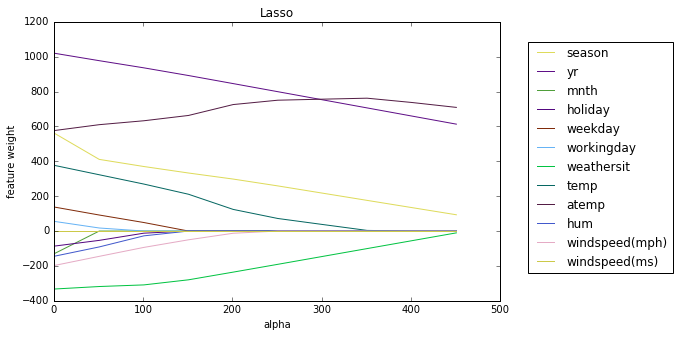

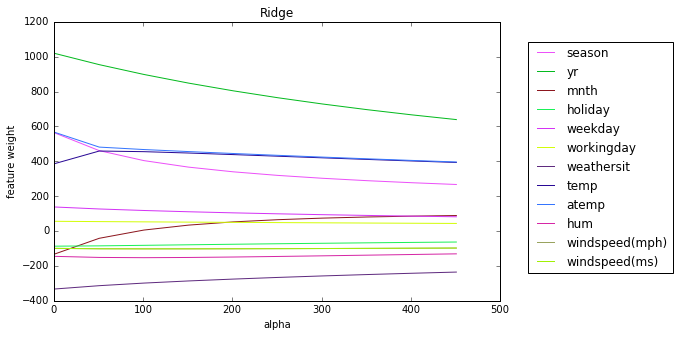

In [197]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 3. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * __Ответ: Lasso__
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * __Ответ: Оптимальные веса будут равняться нулям, так как при оптимизации соответствующей регрессионной задачи при большой параметре альфа оптимальным будет занулить все веса.__
3. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * __Ответ:  Да, про Lasso так утверждать можно, про Ridge-регрессию - нет.__
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * __Ответ: Lasso__

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [198]:
from sklearn.linear_model import LassoCV

Alpha = 96 : Mean = 851097.976
Alpha = 91 : Mean = 844888.212
Alpha = 86 : Mean = 839042.309
Alpha = 81 : Mean = 833559.179
Alpha = 76 : Mean = 828438.728
Alpha = 71 : Mean = 823680.877
Alpha = 66 : Mean = 819285.555
Alpha = 61 : Mean = 815252.699
Alpha = 56 : Mean = 811582.253
Alpha = 51 : Mean = 808274.166
Alpha = 46 : Mean = 805329.651
Alpha = 41 : Mean = 802745.812
Alpha = 36 : Mean = 800525.558
Alpha = 31 : Mean = 798642.913
Alpha = 26 : Mean = 796928.775
Alpha = 21 : Mean = 795177.43
Alpha = 16 : Mean = 793826.018
Alpha = 11 : Mean = 792028.115
Alpha = 6 : Mean = 790397.728
Alpha = 1 : Mean = 825435.812

Minimum of MSE corresponds to the alpha = 6

Coefficients for alpha = 6:

season : 532.019
yr : 1015.06
mnth : -100.04
holiday : -83.294
weekday : 132.504
workingday : 51.557
weathersit : -330.56
temp : 370.68
atemp : 581.397
hum : -140.007
windspeed(mph) : -191.771
windspeed(ms) : -0.0


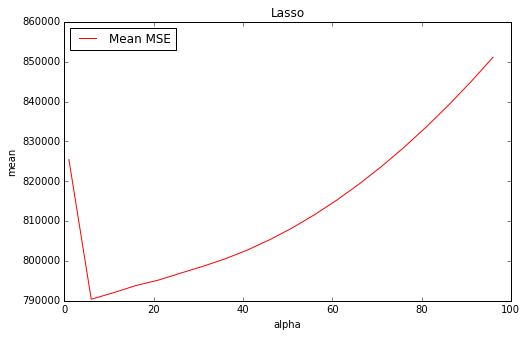

In [199]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
Lasso32 = LassoCV(alphas=alphas, cv=3)
Lasso32.fit(X,y)
MSE_mean = sum(Lasso32.mse_path_.T)/3

for alpha, mean in zip(Lasso32.alphas_, MSE_mean):
    print("Alpha = "+str(alpha)+" : Mean = "+str(round(mean,3)))

print
print "Minimum of MSE corresponds to the alpha = "+str(Lasso32.alphas_[np.argmin(MSE_mean)])
    
plt.figure(figsize=(8, 5))
plt.plot(Lasso32.alphas_, MSE_mean, label='Mean MSE', color='red')
plt.legend(loc="upper left")
plt.xlabel("alpha")
plt.ylabel("mean")
plt.title("Lasso")

print
print "Coefficients for alpha = "+str(Lasso32.alphas_[np.argmin(MSE_mean)])+":"
print

for i, coef in zip(range(len(df.columns[:-1])),Lasso32.coef_):
    print(str(df.columns[i])+" : "+str(round(coef,rnd)))



Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Minimum for alpha in fold = 1 equals 41
Minimum for alpha in fold = 2 equals 6
Minimum for alpha in fold = 3 equals 1


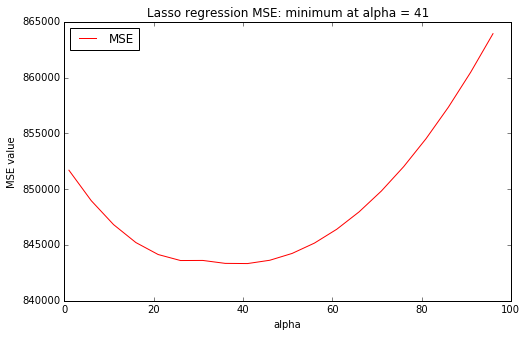

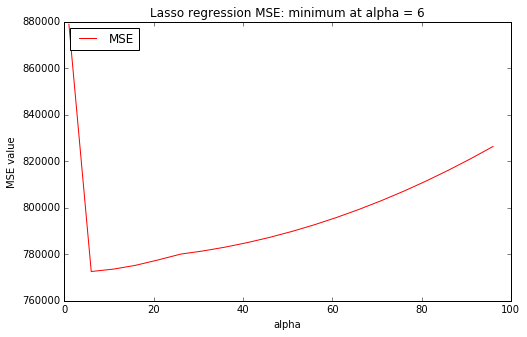

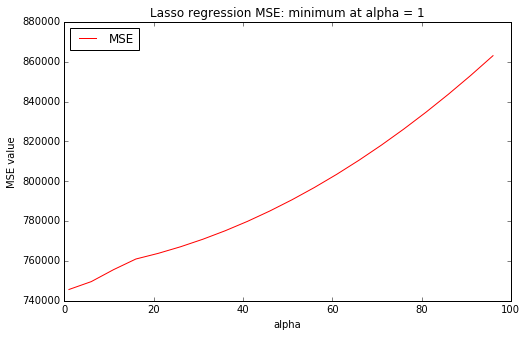

In [200]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
print "Minimum for alpha in fold = 1 equals "+str(Lasso32.alphas_[np.argmin(Lasso32.mse_path_.T[0])])
plt.figure(figsize=(8, 5))
plt.plot(Lasso32.alphas_, Lasso32.mse_path_.T[0], label='MSE', color='red')
plt.legend(loc="upper left")
plt.xlabel("alpha")
plt.ylabel("MSE value")
plt.title("Lasso regression MSE: minimum at alpha = "+str(Lasso32.alphas_[np.argmin(Lasso32.mse_path_.T[0])]))

print "Minimum for alpha in fold = 2 equals "+str(Lasso32.alphas_[np.argmin(Lasso32.mse_path_.T[1])])
plt.figure(figsize=(8, 5))
plt.plot(Lasso32.alphas_, Lasso32.mse_path_.T[1], label='MSE', color='red')
plt.legend(loc="upper left")
plt.xlabel("alpha")
plt.ylabel("MSE value")
plt.title("Lasso regression MSE: minimum at alpha = "+str(Lasso32.alphas_[np.argmin(Lasso32.mse_path_.T[1])]))

print "Minimum for alpha in fold = 3 equals "+str(Lasso32.alphas_[np.argmin(Lasso32.mse_path_.T[2])])
plt.figure(figsize=(8, 5))
plt.plot(Lasso32.alphas_, Lasso32.mse_path_.T[2], label='MSE', color='red')
plt.legend(loc="upper left")
plt.xlabel("alpha")
plt.ylabel("MSE value")
plt.title("Lasso regression MSE: minimum at alpha = "+str(Lasso32.alphas_[np.argmin(Lasso32.mse_path_.T[2])]))

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 4. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * __Ответ: [season, year, temp, atemp]. Возрастающая зависимость в принципе видна, но утверждать что при увеличении значений этих параметров все больше людей захотят брать в аренду велосипеды нельзя. Так можно утверждать лишь про параметры temp и atemp - температуру и температуру по ощущениям__
2. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * __Ответ: [weathersit, hum, windspeed(mph)]. Убывающая зависимость по этим параметрам хорошо видна по графикам. Утверждать обратную зависимость спроса на велосипеды от величины данных параметро вполне логично просто исходя из их смысла. Чем хуже погода или чем больше влажность или чем выше скорость ветра, тем меньше будет браться в аренду велосипедов.__ 
3. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * __Ответ: windspeed(ms). Очевидно, что спрос на аренду велосипедов зависит от этого признака, но его исключение из модели произошло по причине мультиколлинеарности с линейно зависимым признаком windspeed(mph).__ 

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.